In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
import numpy as np
import xesmf as xe

import cmocean
import pandas as pd
import modules.basic_stats as bst
import modules.plotting_module as pltm
import xesmf as xe
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
source_id='CanESM5'
experiment_id=['historical', 'amip']
member_id='r1i1p2f1'
start = '1981-01-01'
end   = '2010-12-31'

# This is the location of the intake database
cat_url = "/space/hall5/sitestore/eccc/crd/ccrn/model_output/intake-catalogues/cccma_cmip6.json"
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# Location of the datasets used for the GMD figures. Should not need changing.
obs_data_path='/home/ncs001/site5/u1_data/canesm5-analysis/cmip6_gmd_figures/'

In [4]:
def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    return ds

In [5]:
col = intake.open_esm_datastore(cat_url)

query = dict(variable_id=['tas'], table_id='Amon', source_id=source_id, experiment_id=experiment_id, member_id=member_id)
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
for k in dset_dict.keys():
    if 'amip' in k:
        amip_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'historical' in k:
        model_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()

In [7]:
# Target grid to remap to. Here a standard 1x1 grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.0)),
                     'lon': (['lon'], np.arange(-180, 180, 1.0)),
                    }
                   )

In [8]:
regridder = xe.Regridder(model_ds, ds_out, 'bilinear', periodic=True)
model_ds_rm = regridder(model_ds)
amip_ds_rm = regridder(amip_ds)

In [9]:
# Load and reamp ERA5 T2m to 1x1 global grid
ERA5_tas = 'era5_tas_monthlymean_1979-2019.nc'

ifile = [os.path.join(obs_data_path, 'input_data/obs/NEIL/era5/', ERA5_tas),        
         ]
era5_ds = xr.open_mfdataset(ifile).rename({'longitude':'lon', 'latitude':'lat', 't2m':'tas'}).sel(time=slice(start, end)).squeeze()

regridder = xe.Regridder(era5_ds, ds_out, 'bilinear', periodic=True)
era5_ds_rm = regridder(era5_ds)

In [10]:
#tas_obsanomaly = tas_mean - tas_obs_mean

model_DJF = pltm.get_seasonal(model_ds_rm,'noleap','DJF')
model_JJA = pltm.get_seasonal(model_ds_rm,'noleap','JJA')

amip_DJF = pltm.get_seasonal(amip_ds_rm,'noleap','DJF')
amip_JJA = pltm.get_seasonal(amip_ds_rm,'noleap','JJA')

era5_DJF = pltm.get_seasonal(era5_ds_rm,'standard','DJF')
era5_JJA = pltm.get_seasonal(era5_ds_rm,'standard','JJA')

seasonal_zms = {
    'tas_DJF':model_DJF.tas, 
    'tas_JJA':model_JJA.tas, 
    'tas_obs_DJF':era5_DJF.tas,
    'tas_obs_JJA':era5_JJA.tas,
    'tas_amip_DJF':amip_DJF.tas,
    'tas_amip_JJA':amip_JJA.tas,
    }   

In [11]:
title_fontsize=12

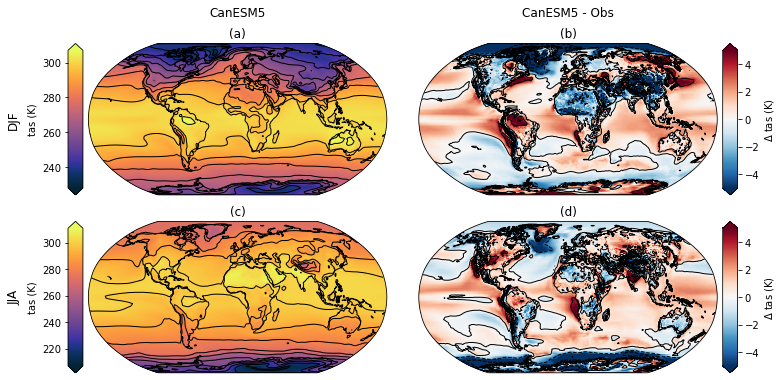

In [12]:
fig = plt.figure(figsize=(12,12))
cmap2=plt.cm.RdBu_r

ax1 = plt.subplot(3,2,1,projection=ccrs.Robinson())
cb_tas = ax1.pcolormesh(seasonal_zms['tas_DJF'].lon, seasonal_zms['tas_DJF'].lat, seasonal_zms['tas_DJF'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax1, cb_tas, extend='both', label =r'tas (K)')
ax1.contour(seasonal_zms['tas_DJF'].lon, seasonal_zms['tas_DJF'].lat, seasonal_zms['tas_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax1.set_title('(a)')
ax1.text(0.5, 1.2, 'CanESM5', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize,
         transform=ax1.transAxes)
ax1.text(-0.25, 0.5, 'DJF', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax1.transAxes)

ax3 = plt.subplot(3,2,2,projection=ccrs.Robinson())
cb_tasan = ax3.pcolormesh(seasonal_zms['tas_DJF'].lon, seasonal_zms['tas_DJF'].lat, seasonal_zms['tas_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax3, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax3.contour(seasonal_zms['tas_DJF'].lon, seasonal_zms['tas_DJF'].lat, seasonal_zms['tas_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax3.set_title('(b)')
ax3.text(0.5, 1.2, 'CanESM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, 
         transform=ax3.transAxes)

ax2 = plt.subplot(3,2,3,projection=ccrs.Robinson())
cb_tas = ax2.pcolormesh(seasonal_zms['tas_JJA'].lon, seasonal_zms['tas_JJA'].lat, seasonal_zms['tas_JJA'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax2, cb_tas, extend='both', label =r'tas (K)')
ax2.contour(seasonal_zms['tas_JJA'].lon, seasonal_zms['tas_JJA'].lat, seasonal_zms['tas_JJA'],
            10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax2.set_title('(c)')
ax2.text(-0.25, 0.5, 'JJA', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax2.transAxes)

ax4 = plt.subplot(3,2,4,projection=ccrs.Robinson())
cb_tasan = ax4.pcolormesh(seasonal_zms['tas_JJA'].lon, seasonal_zms['tas_JJA'].lat, seasonal_zms['tas_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax4, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax4.contour(seasonal_zms['tas_JJA'].lon, seasonal_zms['tas_JJA'].lat, seasonal_zms['tas_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax4.set_title('(d)')

fig.subplots_adjust(wspace=0.1, hspace=-0.4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.coastlines()

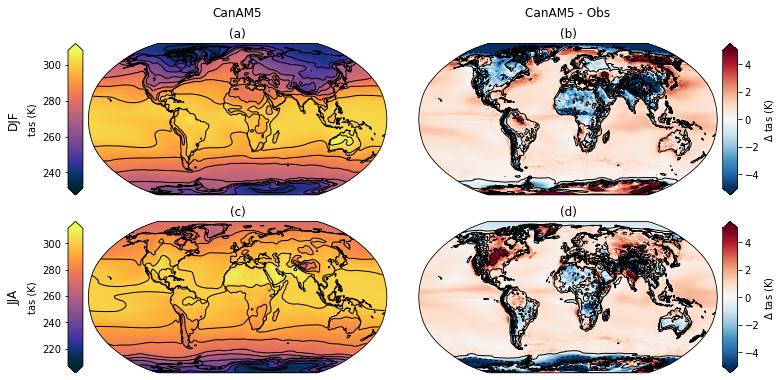

In [13]:
fig = plt.figure(figsize=(12,12))
cmap2=plt.cm.RdBu_r

ax1 = plt.subplot(3,2,1,projection=ccrs.Robinson())
cb_tas = ax1.pcolormesh(seasonal_zms['tas_amip_DJF'].lon, seasonal_zms['tas_amip_DJF'].lat, seasonal_zms['tas_amip_DJF'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax1, cb_tas, extend='both', label =r'tas (K)')
ax1.contour(seasonal_zms['tas_amip_DJF'].lon, seasonal_zms['tas_amip_DJF'].lat, seasonal_zms['tas_amip_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax1.set_title('(a)')
ax1.text(0.5, 1.2, 'CanAM5', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize,
         transform=ax1.transAxes)
ax1.text(-0.25, 0.5, 'DJF', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax1.transAxes)

ax3 = plt.subplot(3,2,2,projection=ccrs.Robinson())
cb_tasan = ax3.pcolormesh(seasonal_zms['tas_amip_DJF'].lon, seasonal_zms['tas_amip_DJF'].lat, seasonal_zms['tas_amip_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax3, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax3.contour(seasonal_zms['tas_amip_DJF'].lon, seasonal_zms['tas_amip_DJF'].lat, seasonal_zms['tas_amip_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax3.set_title('(b)')
ax3.text(0.5, 1.2, 'CanAM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, 
         transform=ax3.transAxes)

ax2 = plt.subplot(3,2,3,projection=ccrs.Robinson())
cb_tas = ax2.pcolormesh(seasonal_zms['tas_amip_JJA'].lon, seasonal_zms['tas_amip_JJA'].lat, seasonal_zms['tas_amip_JJA'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax2, cb_tas, extend='both', label =r'tas (K)')
ax2.contour(seasonal_zms['tas_amip_JJA'].lon, seasonal_zms['tas_amip_JJA'].lat, seasonal_zms['tas_amip_JJA'],
            10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax2.set_title('(c)')
ax2.text(-0.25, 0.5, 'JJA', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax2.transAxes)

ax4 = plt.subplot(3,2,4,projection=ccrs.Robinson())
cb_tasan = ax4.pcolormesh(seasonal_zms['tas_amip_JJA'].lon, seasonal_zms['tas_amip_JJA'].lat, seasonal_zms['tas_amip_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax4, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax4.contour(seasonal_zms['tas_amip_JJA'].lon, seasonal_zms['tas_amip_JJA'].lat, seasonal_zms['tas_amip_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax4.set_title('(d)')

fig.subplots_adjust(wspace=0.1, hspace=-0.4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.coastlines()
    ax.set_global()

In [14]:
source_id='CanESM2'
experiment_id='historical'
member_id='r1i1p1'
start = '1981-01-01'
end   = '2005-12-31'

# This is the location of the intake database
cat_url = "/space/hall5/sitestore/eccc/crd/ccrn/model_output/intake-catalogues/cccma_cmip5.json"
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# Location of the datasets used for the GMD figures. Should not need changing.
obs_data_path='/home/ncs001/runpath4/canesm5-analysis/cmip6_gmd_figures'

In [15]:
col = intake.open_esm_datastore(cat_url)

query = dict(variable=['tas'], model=source_id, experiment=experiment_id, ensemble_member=member_id, mip_table='Amon')
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'


In [16]:
for k in dset_dict.keys():
    if 'amip' in k:
        amip_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'historical' in k:
        model_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()

In [17]:
regridder = xe.Regridder(model_ds, ds_out, 'bilinear', periodic=True)
canesm_ds_rm = regridder(model_ds)

In [18]:
canesm2_DJF = pltm.get_seasonal(model_ds_rm,'noleap','DJF')
canesm2_JJA = pltm.get_seasonal(model_ds_rm,'noleap','JJA')
seasonal_zms['tas_canesm2_DJF'] =  canesm2_DJF.tas 
seasonal_zms['tas_canesm2_JJA'] = canesm2_JJA.tas

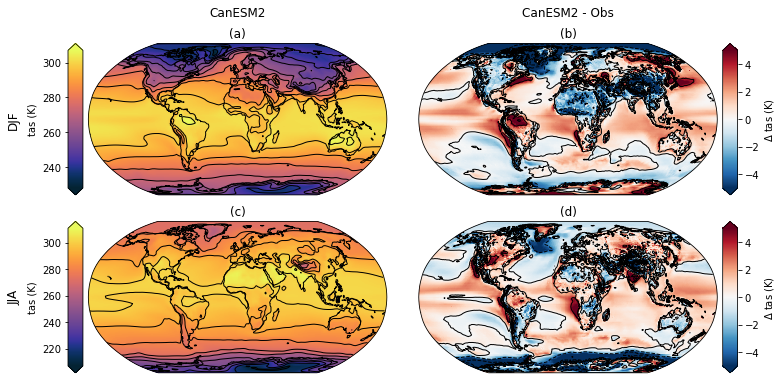

In [19]:
fig = plt.figure(figsize=(12,12))
cmap2=plt.cm.RdBu_r

ax1 = plt.subplot(3,2,1,projection=ccrs.Robinson())
cb_tas = ax1.pcolormesh(seasonal_zms['tas_canesm2_DJF'].lon, seasonal_zms['tas_canesm2_DJF'].lat, seasonal_zms['tas_canesm2_DJF'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax1, cb_tas, extend='both', label =r'tas (K)')
ax1.contour(seasonal_zms['tas_canesm2_DJF'].lon, seasonal_zms['tas_canesm2_DJF'].lat, seasonal_zms['tas_canesm2_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax1.set_title('(a)')
ax1.text(0.5, 1.2, 'CanESM2', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize,
         transform=ax1.transAxes)
ax1.text(-0.25, 0.5, 'DJF', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax1.transAxes)

ax3 = plt.subplot(3,2,2,projection=ccrs.Robinson())
cb_tasan = ax3.pcolormesh(seasonal_zms['tas_canesm2_DJF'].lon, seasonal_zms['tas_canesm2_DJF'].lat, seasonal_zms['tas_canesm2_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax3, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax3.contour(seasonal_zms['tas_canesm2_DJF'].lon, seasonal_zms['tas_canesm2_DJF'].lat, seasonal_zms['tas_canesm2_DJF'] - 
                          seasonal_zms['tas_obs_DJF'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax3.set_title('(b)')
ax3.text(0.5, 1.2, 'CanESM2 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, 
         transform=ax3.transAxes)

ax2 = plt.subplot(3,2,3,projection=ccrs.Robinson())
cb_tas = ax2.pcolormesh(seasonal_zms['tas_canesm2_JJA'].lon, seasonal_zms['tas_canesm2_JJA'].lat, seasonal_zms['tas_canesm2_JJA'], 
                        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, ax2, cb_tas, extend='both', label =r'tas (K)')
ax2.contour(seasonal_zms['tas_canesm2_JJA'].lon, seasonal_zms['tas_canesm2_JJA'].lat, seasonal_zms['tas_canesm2_JJA'],
            10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax2.set_title('(c)')
ax2.text(-0.25, 0.5, 'JJA', horizontalalignment='center', verticalalignment='center',rotation='vertical', 
         fontsize=title_fontsize, transform=ax2.transAxes)

ax4 = plt.subplot(3,2,4,projection=ccrs.Robinson())
cb_tasan = ax4.pcolormesh(seasonal_zms['tas_canesm2_JJA'].lon, seasonal_zms['tas_canesm2_JJA'].lat, seasonal_zms['tas_canesm2_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], cmap=cmap2,vmin=-5, vmax=5, transform=ccrs.PlateCarree(), rasterized=True) 
pltm.add_cbar('right', fig, ax4, cb_tasan, extend='both', label =r'$\Delta$ tas (K)')
ax4.contour(seasonal_zms['tas_canesm2_JJA'].lon, seasonal_zms['tas_canesm2_JJA'].lat, seasonal_zms['tas_canesm2_JJA'] - 
                          seasonal_zms['tas_obs_JJA'], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
ax4.set_title('(d)')

fig.subplots_adjust(wspace=0.1, hspace=-0.4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.coastlines()

## Look at snow on sea-ice

In [20]:
source_id='CanESM5'
experiment_id=['historical', 'amip']
member_id='r1i1p2f1'
start = '1981-01-01'
end   = '2010-12-31'

# This is the location of the intake database
cat_url = "/space/hall5/sitestore/eccc/crd/ccrn/model_output/intake-catalogues/cccma_cmip6.json"
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# Location of the datasets used for the GMD figures. Should not need changing.
obs_data_path='/home/ncs001/site5/u1_data/canesm5-analysis/cmip6_gmd_figures/'

In [21]:
col = intake.open_esm_datastore(cat_url)

query = dict(variable_id='snd', table_id='LImon', source_id=source_id, experiment_id='historical', member_id=member_id)
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [22]:
snd = dset_dict['CMIP.CCCma.CanESM5.historical.LImon.gn']

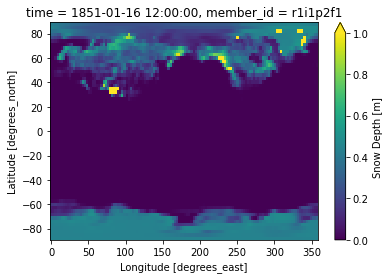

In [23]:
snd.snd.isel(time=12).plot(vmin=0,vmax=1)

In [24]:
col = intake.open_esm_datastore(cat_url)

query = dict(variable_id='sithick', table_id='SImon', source_id=source_id, experiment_id='historical', member_id=member_id)
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


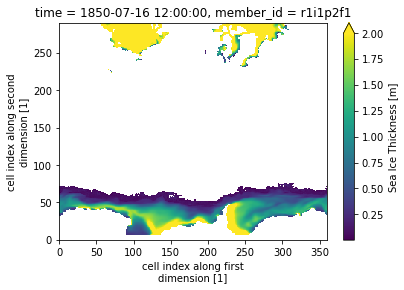

In [25]:
dset_dict['CMIP.CCCma.CanESM5.historical.SImon.gn'].sithick.isel(time=6).plot(vmax=2)

## Look at Duo's run reducing snow conductivity, relative to a piControl

In [26]:
ls /space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/esm-pi-sc/data/nc_output/CMIP6

CCCma/


In [27]:
tas_cmip6_pi = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/model_output/CMIP6/final/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_piControl_r1i1p2f1_gn_600101-620012.nc')
tas_dyref = xr.open_mfdataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/esm-ref2/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-esm-ref2/piControl/r1i1p1f1/Amon/tas/gn/v20190429/tas_*.nc')
tas_dycons = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/esm-pi-sc/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-esm-pi-sc/piControl/r1i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5-esm-pi-sc_piControl_r1i1p1f1_gn_600001-610012.nc')

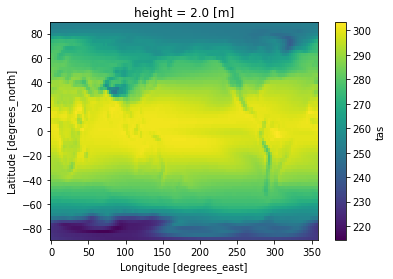

In [28]:
tas_cmip6_pi.tas.mean(dim='time').plot()

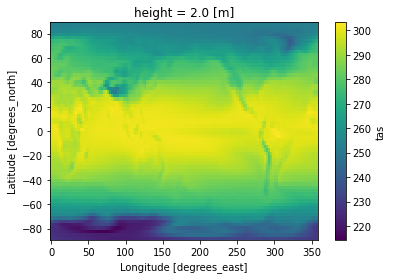

In [29]:
tas_dyref.tas.mean(dim='time').plot()

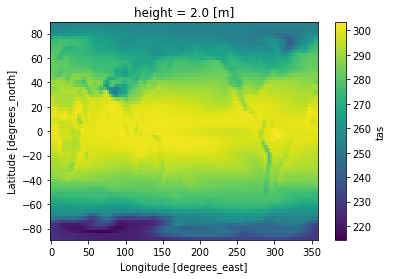

In [30]:
tas_dycons.tas.mean(dim='time').plot()

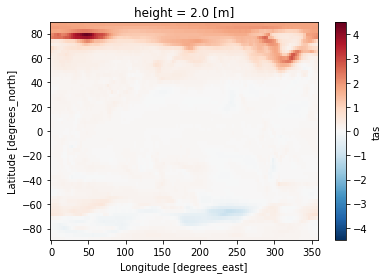

In [31]:
(tas_dycons.tas.mean(dim='time') - tas_dyref.tas.mean(dim='time')).plot()

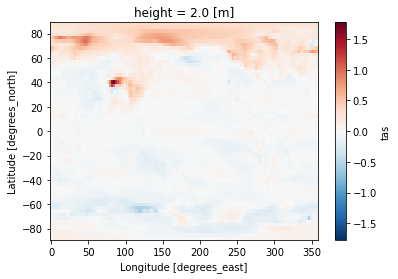

In [32]:
(tas_dyref.tas.mean(dim='time') - tas_cmip6_pi.tas.mean(dim='time')).plot()